In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   

In [2]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'split_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")    # Apple Silicon GPUs
else:
    device = torch.device("cpu")

print(f"Using {device} device")


Using cuda device


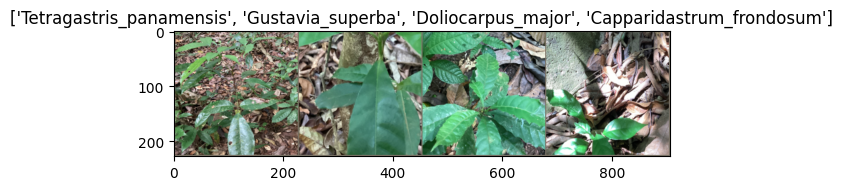

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience (int): Number of epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=40):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        training_loss = []
        validation_loss = []
        training_accuracy = []
        validation_accuracy = []

                

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

    
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  
                else:
                    model.eval()  

                running_loss = 0.0
                running_corrects = 0

        
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

           
                    optimizer.zero_grad()

           
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'train':
                    training_loss.append(epoch_loss)
                    training_accuracy.append(epoch_acc)
                else:
                    validation_loss.append(epoch_loss)
                    validation_accuracy.append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, training_loss, validation_loss, training_accuracy, validation_accuracy    

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft, training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 2.7728 Acc: 0.2470
val Loss: 2.4158 Acc: 0.3302

Epoch 1/29
----------
train Loss: 2.5402 Acc: 0.2947
val Loss: 2.1245 Acc: 0.4341

Epoch 2/29
----------
train Loss: 2.3901 Acc: 0.3294
val Loss: 2.0990 Acc: 0.4750

Epoch 3/29
----------
train Loss: 2.2920 Acc: 0.3616
val Loss: 2.2881 Acc: 0.4453

Epoch 4/29
----------
train Loss: 2.1642 Acc: 0.4113
val Loss: 2.4712 Acc: 0.4323

Epoch 5/29
----------
train Loss: 2.0419 Acc: 0.4240
val Loss: 1.8152 Acc: 0.5083

Epoch 6/29
----------
train Loss: 1.6553 Acc: 0.5267
val Loss: 1.3382 Acc: 0.6401

Epoch 7/29
----------
train Loss: 1.4757 Acc: 0.5768
val Loss: 1.2700 Acc: 0.6512

Epoch 8/29
----------
train Loss: 1.3987 Acc: 0.6090
val Loss: 1.2637 Acc: 0.6716

Epoch 9/29
----------
train Loss: 1.3898 Acc: 0.6070
val Loss: 1.1985 Acc: 0.6716

Epoch 10/29
----------
train Loss: 1.3568 Acc: 0.6265
val Loss: 1.2026 Acc: 0.6772

Epoch 11/29
----------
train Loss: 1.2792 Acc: 0.6587
val Loss: 1.2100 Acc: 0.6809

Ep

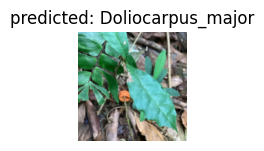

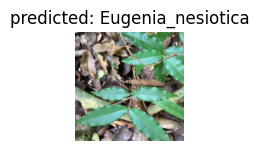

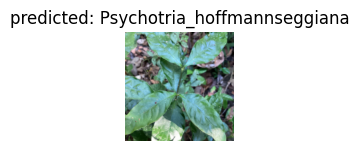

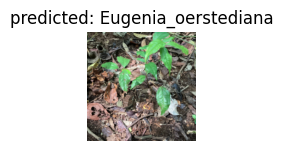

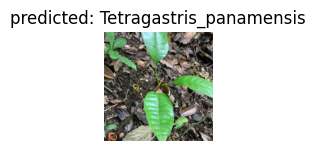

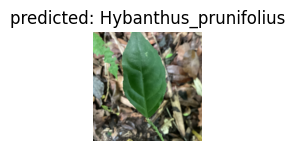

In [10]:
visualize_model(model_ft)

In [11]:
training_accuracy = [x.cpu().item() if torch.is_tensor(x) else x for x in training_accuracy]
validation_accuracy = [x.cpu().item() if torch.is_tensor(x) else x for x in validation_accuracy]

In [12]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)

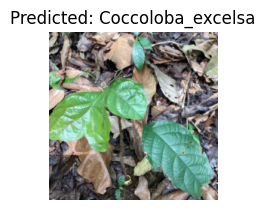

In [13]:
visualize_model_predictions(
    model_ft,
    img_path='split_data/val/Paullinia_turbacensis/9000660_264836120_475601975.jpg'
)

plt.ioff()
plt.show()

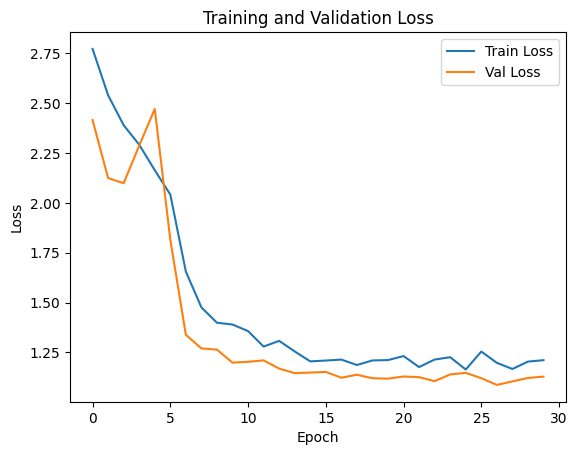

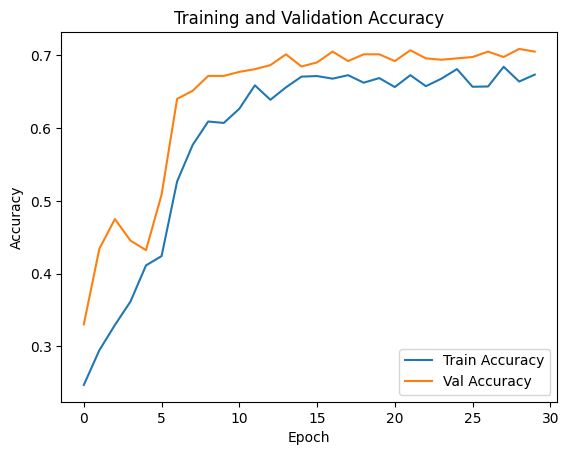

In [14]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(training_loss, label='Train Loss')
plt.plot(validation_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(training_accuracy, label='Train Accuracy')
plt.plot(validation_accuracy, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


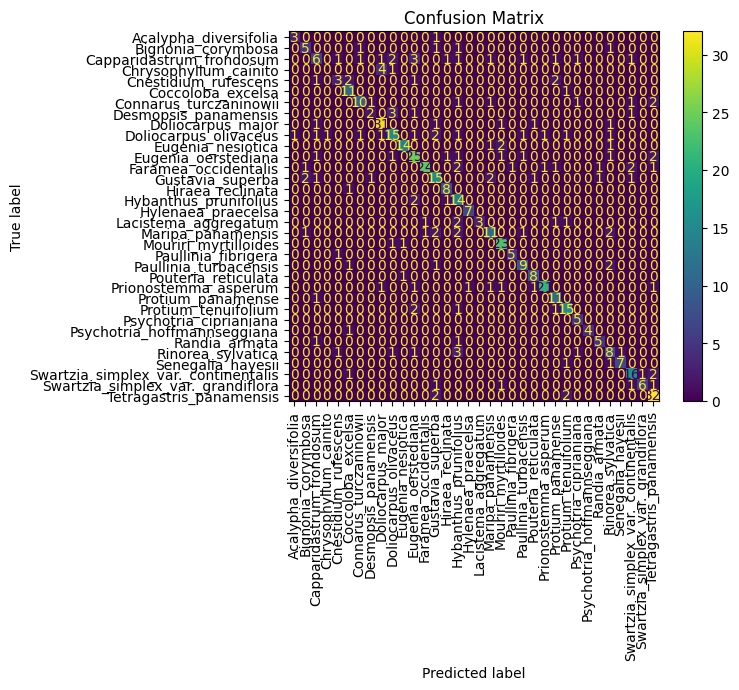

In [15]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


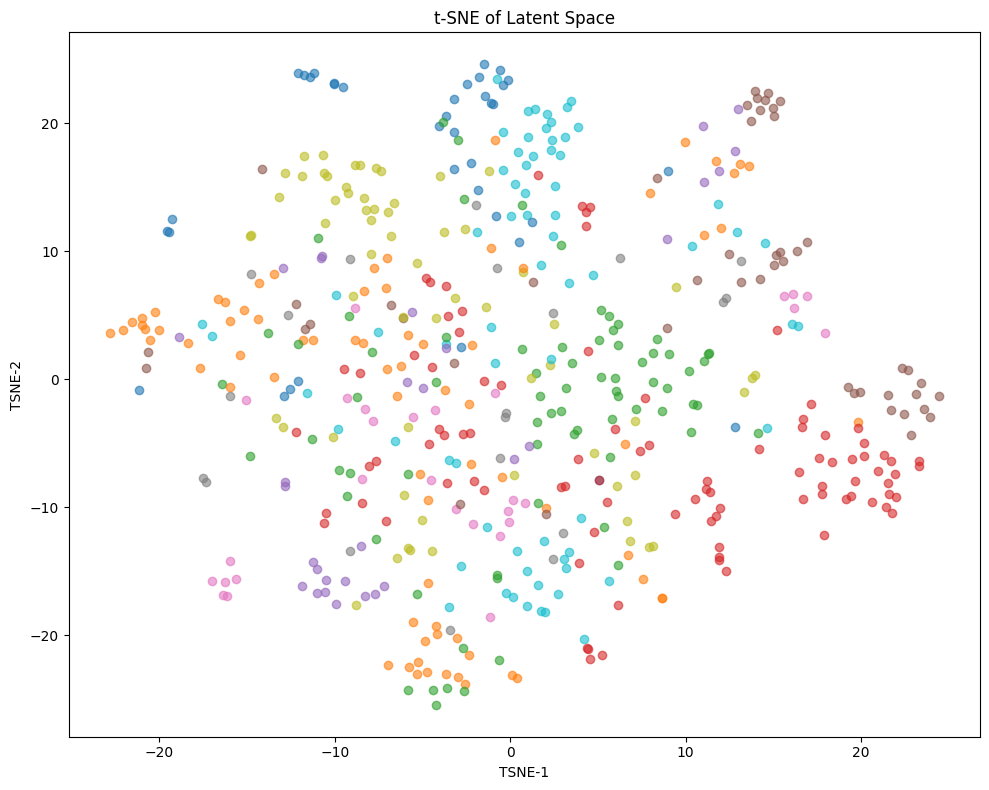

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

features = []
labels_list = []

model_ft.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model_ft(inputs)
        features.extend(outputs.cpu().numpy())
        labels_list.extend(labels.numpy())


from sklearn.manifold import TSNE

features = np.array(features) 
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

tsne_results = np.array(tsne_results)
labels_list = np.array(labels_list)

# Plot with matplotlib
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    idx = labels_list == i
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=class_name, alpha=0.6)

# plt.legend()
plt.title('t-SNE of Latent Space')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.tight_layout()
plt.show()

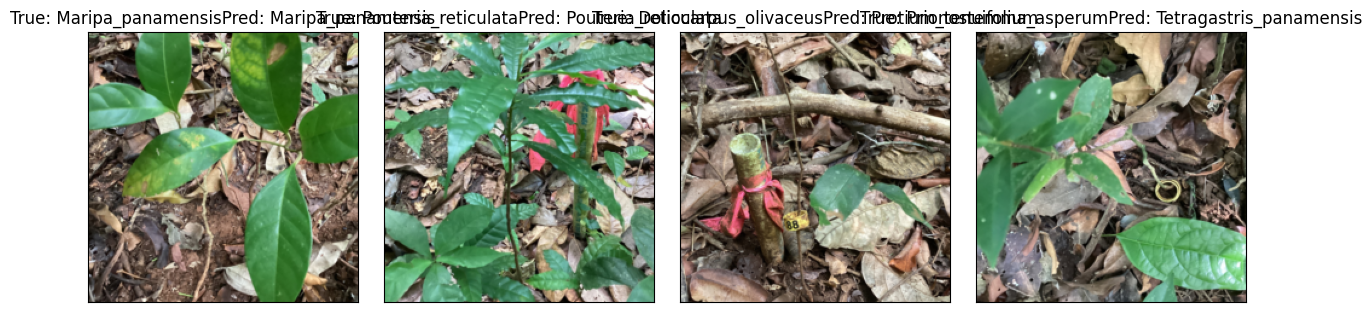

In [17]:

model_ft.eval()
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 6))
for idx in range(min(len(inputs), 8)):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    inp = inputs.cpu().data[idx].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    ax.set_title(f"True: {class_names[labels[idx]]}Pred: {class_names[preds[idx]]}")
plt.tight_layout()
plt.show()

Adjusted Rand Index (ARI): 0.1881
Silhouette Score: 0.1046


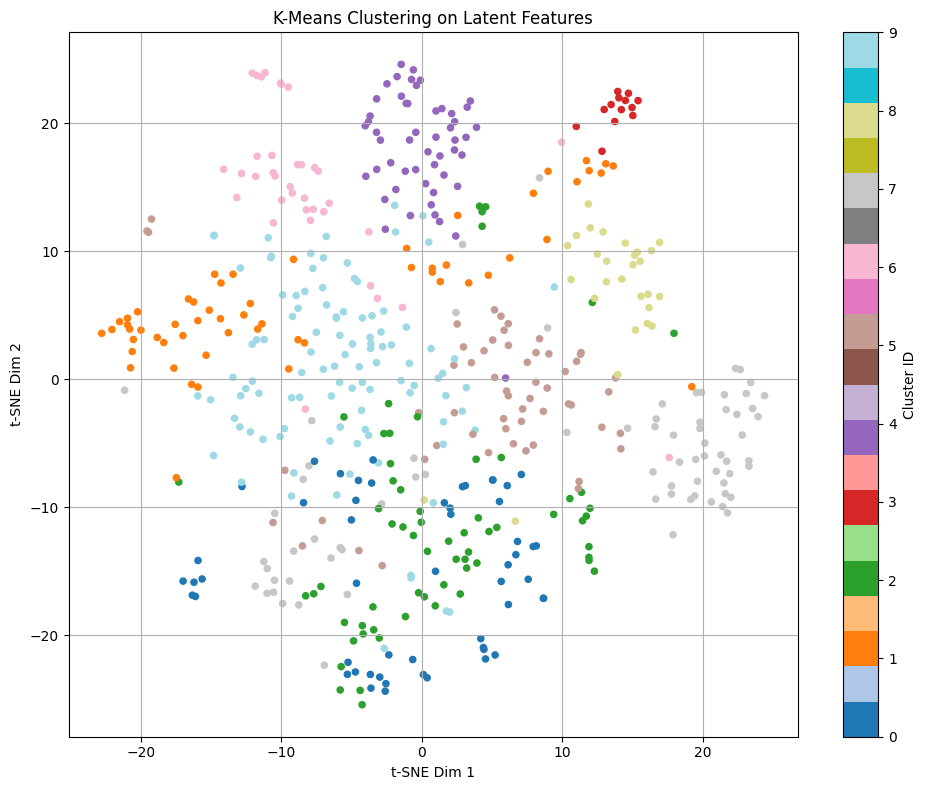

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

features = np.array(features)
true_labels = np.array(labels_list)

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

ari = adjusted_rand_score(true_labels, cluster_labels)
sil_score = silhouette_score(features, cluster_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='tab20', s=20)
plt.title("K-Means Clustering on Latent Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.colorbar(scatter, label='Cluster ID')
plt.tight_layout()
plt.show()